In [1]:
import mne
import numpy as np
from scipy.io import loadmat
import pandas as pd
import matplotlib.pyplot as plt
# Load the .mat file




In [2]:
mat_data = loadmat('./EEG_downsample/20180413_001.mat')
eeg_data = (mat_data['EEG']['data'][0, 0])*1e-6
channel_names = [ch[0] for ch in mat_data['EEG']['chanlocs'][0, 0]['labels'][0]]
sampling_freq = mat_data['EEG']['srate'][0, 0][0, 0]

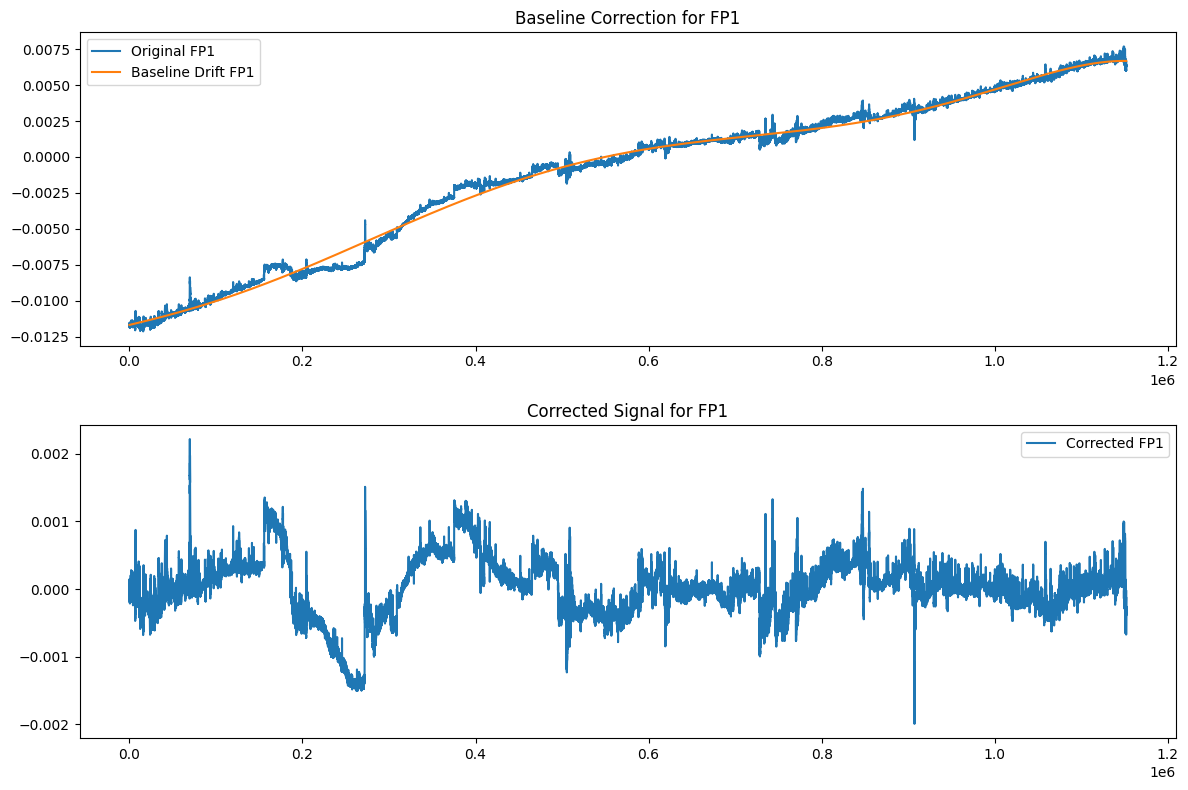

In [3]:
# Baseline Correction
fp1_index = channel_names.index('FP1')
fp2_index = channel_names.index('FP2')

# Fit a 6th order polynomial to the baseline drift for FP1
baseline_poly_fp1 = np.polyfit(np.arange(len(eeg_data[fp1_index])), eeg_data[fp1_index], 6)
baseline_drift_fp1 = np.polyval(baseline_poly_fp1, np.arange(len(eeg_data[fp1_index])))

# Fit a 6th order polynomial to the baseline drift for FP2
baseline_poly_fp2 = np.polyfit(np.arange(len(eeg_data[fp2_index])), eeg_data[fp2_index], 6)
baseline_drift_fp2 = np.polyval(baseline_poly_fp2, np.arange(len(eeg_data[fp2_index])))

# Subtract the baseline drifts from the original signals
eeg_data_corrected = np.copy(eeg_data)
eeg_data_corrected[fp1_index] -= baseline_drift_fp1
eeg_data_corrected[fp2_index] -= baseline_drift_fp2

# Plot the original and corrected signals for FP1 and FP2
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(eeg_data[fp1_index], label='Original FP1')
plt.plot(baseline_drift_fp1, label='Baseline Drift FP1')
plt.title('Baseline Correction for FP1')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(eeg_data_corrected[fp1_index], label='Corrected FP1')
plt.title('Corrected Signal for FP1')
plt.legend()

plt.tight_layout()
plt.show()


In [4]:
# Baseline correction
fp1_index = channel_names.index('FP1')
fp2_index = channel_names.index('FP2')
selected_channels_data = eeg_data[[fp1_index, fp2_index], :]
baseline_poly_fp1 = np.polyfit(np.arange(len(eeg_data[fp1_index])), eeg_data[fp1_index], 6)  # Fit a 6th order polynomial to the baseline drift for each channel
baseline_poly_fp2 = np.polyfit(np.arange(len(eeg_data[fp2_index])), eeg_data[fp2_index], 6)
baseline_drift_fp1 = np.polyval(baseline_poly_fp1, np.arange(len(eeg_data[fp1_index])))
baseline_drift_fp2 = np.polyval(baseline_poly_fp2, np.arange(len(eeg_data[fp2_index])))   # Evaluate the polynomials at all time points to get the baseline drifts
eeg_data[fp1_index] -= baseline_drift_fp1   # Subtract the baseline drifts from the original signals
eeg_data[fp2_index] -= baseline_drift_fp2



Creating RawArray with float64 data, n_channels=2, n_times=1152118
    Range : 0 ... 1152117 =      0.000 ...  4608.468 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 75 samples (0.300 s)

Using matplotlib as 2D backend.


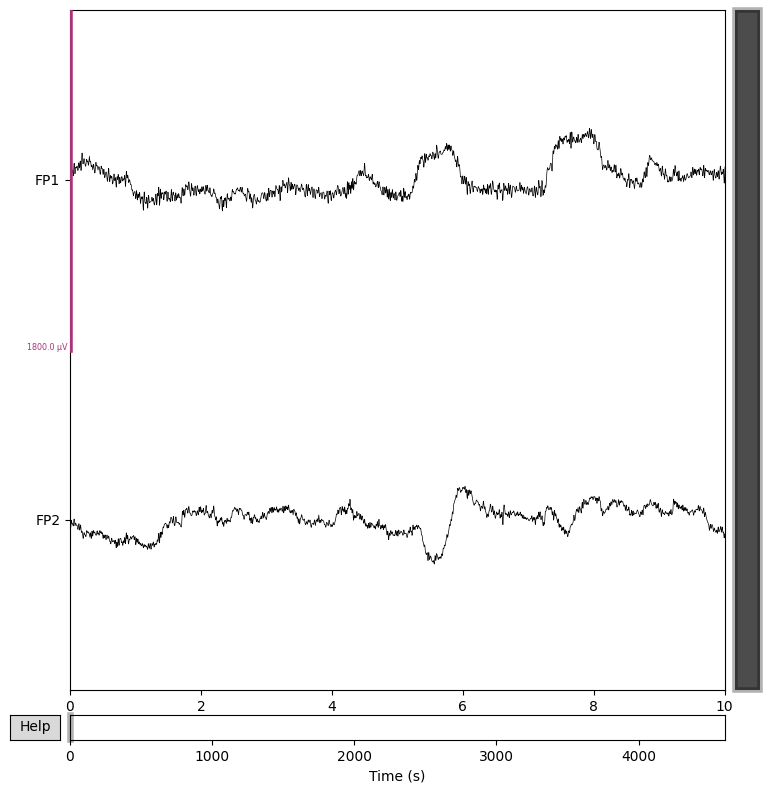

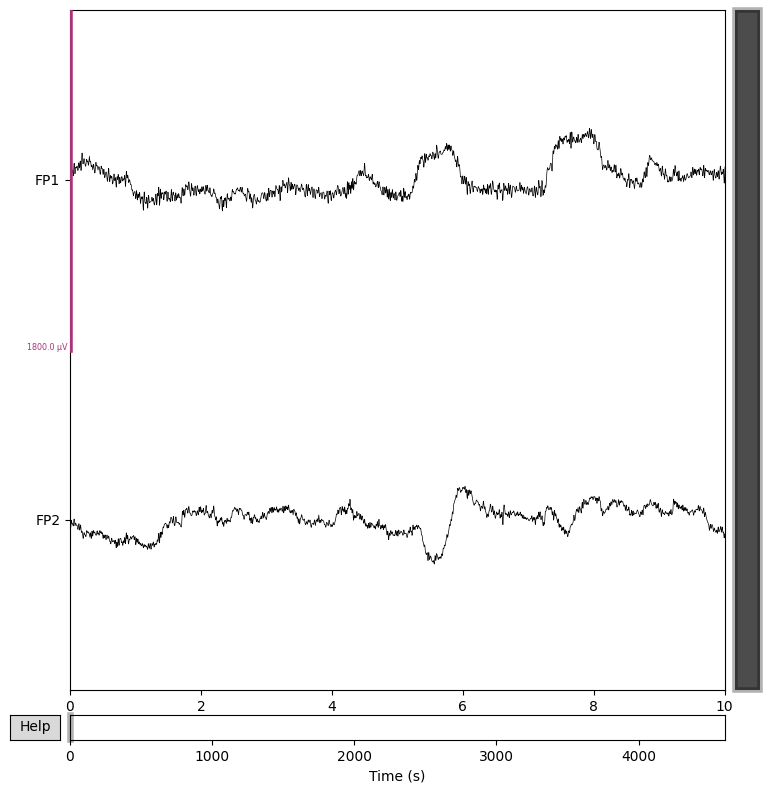

In [5]:
# Create MNE info object
info = mne.create_info(['FP1', 'FP2'], sampling_freq, ch_types='eeg')
raw = mne.io.RawArray(eeg_data[[fp1_index, fp2_index], :], info)
raw.filter(0,45.0)
scalings = {'eeg': 0.0009}
raw.plot(n_channels=2, scalings=scalings, duration=10)

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 8.192 (s)


C:\Users\Administrator\AppData\Local\Temp\ipykernel_19424\2847632005.py:1: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.plot_psd()
c:\Users\Administrator\AppData\Local\Programs\Python\Python312\Lib\site-packages\mne\viz\utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


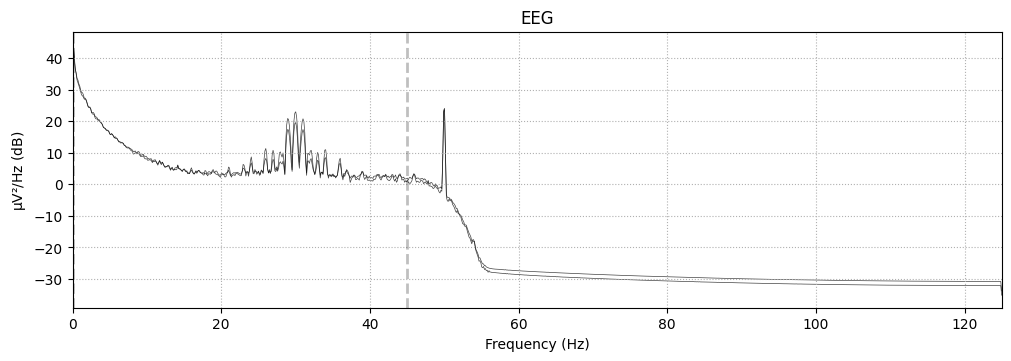

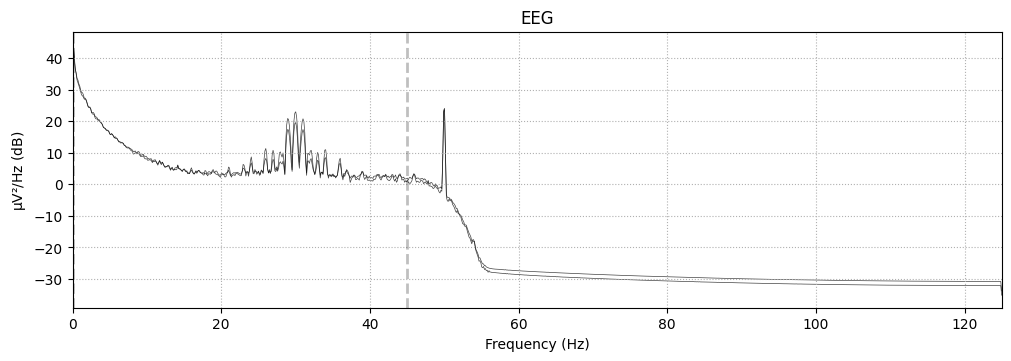

In [6]:
raw.plot_psd()

In [7]:
# Getting The raw data
df=raw.get_data()

In [8]:
# Dividing into Chunks
fs=250
time=2
chunk_size=fs*time
n_chunks=df.shape[1]//chunk_size
df=df[:,:n_chunks*chunk_size]
df_new=np.split(df,n_chunks,axis=1)

In [9]:
df.shape[1]//chunk_size

2304

In [10]:
# Normalization of eeg data
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()
filtered_df=[]
for i in range(len(df_new)):
    x=df_new[i]
    x=x.T
    x=scaler.fit_transform(x)
    x=x.T
    filtered_df.append(x)
filtered_df=np.array(filtered_df)


In [11]:
np.array(filtered_df).shape

(2304, 2, 500)

In [12]:
## fft Feature extraction
fft_features=[]
for j in range(len(filtered_df)):
    chunk=filtered_df[j]
    segg=[]
    for i in range(chunk.shape[0]):
        fourier = np.abs(np.fft.fft(chunk[i, :]))
        segg.append(fourier)
    final_concate = np.concatenate(segg, axis=0)
    fft_features.append(final_concate)
fft_features=np.array(fft_features)
print(fft_features.shape)

(2304, 1000)


In [13]:
# Manual Frequency based Features
from scipy import stats
def mean(data):
    return np.mean(data,axis=-1)
    
def std(data):
    return np.std(data,axis=-1)

def ptp(data):
    return np.ptp(data,axis=-1)

def var(data):
        return np.var(data,axis=-1)

def minim(data):
      return np.min(data,axis=-1)


def maxim(data):
      return np.max(data,axis=-1)

def argminim(data):
      return np.argmin(data,axis=-1)


def argmaxim(data):
      return np.argmax(data,axis=-1)

def mean_square(data):
      return np.mean(data**2,axis=-1)

def rms(data): #root mean square
      return  np.sqrt(np.mean(data**2,axis=-1))  

def abs_diffs_signal(data):
    return np.sum(np.abs(np.diff(data,axis=-1)),axis=-1)


def skewness(data):
    return stats.skew(data,axis=-1)

def kurtosis(data):
    return stats.kurtosis(data,axis=-1)

def concatenate_features(data):
    return np.concatenate((mean(data),std(data),ptp(data),var(data),minim(data),maxim(data),argminim(data),argmaxim(data),
                          mean_square(data),rms(data),abs_diffs_signal(data),
                          skewness(data),kurtosis(data)),axis=-1)

manual_features=[]
for d in filtered_df:
     manual_features.append(concatenate_features(d))

manual_features=np.array(manual_features)
print(manual_features.shape)
     


(2304, 26)


In [14]:
df.shape

(2, 1152000)

In [15]:
#  eeg Power
import neurokit2 as nk
import pandas as pd

eeg_power = nk.eeg_power(df, sampling_rate=250)

# Display EEG power spectrum
print(eeg_power.head())



  Channel         Gamma          Beta         Alpha         Theta     Delta
0   EEG_0  6.922239e-07  3.722614e-07  1.639466e-07  6.910740e-07  0.000005
1   EEG_1  7.845349e-07  5.420487e-07  1.747479e-07  6.799397e-07  0.000006


In [16]:
# Reshape eeg_power DataFrame for feature extraction
eeg_power_features = eeg_power.set_index('Channel').stack().reset_index()
eeg_power_features.columns = ['Channel', 'FrequencyBand', 'Power']

# Display reshaped DataFrame
print(eeg_power_features)



  Channel FrequencyBand         Power
0   EEG_0         Gamma  6.922239e-07
1   EEG_0          Beta  3.722614e-07
2   EEG_0         Alpha  1.639466e-07
3   EEG_0         Theta  6.910740e-07
4   EEG_0         Delta  5.333865e-06
5   EEG_1         Gamma  7.845349e-07
6   EEG_1          Beta  5.420487e-07
7   EEG_1         Alpha  1.747479e-07
8   EEG_1         Theta  6.799397e-07
9   EEG_1         Delta  5.534851e-06


In [17]:
# Reshape eeg_power DataFrame for feature extraction
eeg_power_features = eeg_power.set_index('Channel').stack().reset_index()
eeg_power_features.columns = ['Channel', 'FrequencyBand', 'Power']

# Extract 'Power' column values as an array
power_values = eeg_power_features['Power'].values

# Display 'Power' column values as an array
print(power_values)


[6.92223934e-07 3.72261396e-07 1.63946581e-07 6.91073998e-07
 5.33386463e-06 7.84534919e-07 5.42048706e-07 1.74747867e-07
 6.79939737e-07 5.53485074e-06]


In [23]:
np.array(eeg_power_features['Power'].values.tolist())

array([6.92223934e-07, 3.72261396e-07, 1.63946581e-07, 6.91073998e-07,
       5.33386463e-06, 7.84534919e-07, 5.42048706e-07, 1.74747867e-07,
       6.79939737e-07, 5.53485074e-06])

In [18]:
# Labels finding
import pandas as pd

df=pd.read_csv('./details/labels.csv')
df.dropna(subset=['Tension (1, 8, 15, 21, 28, and 35)'],inplace=True)

In [19]:
df['ID']

0      1
1      2
2      3
3      4
4      5
      ..
84    85
85    86
86    87
87    88
88    89
Name: ID, Length: 88, dtype: int64

In [20]:
# Checking Numer of healhty and Anxiety patients
healthy=0
anxiety=0
for i in labels_range:
    if i<16:
        healthy=healthy+1
    else:
        anxiety=anxiety+1
print("Healthy Patients: ",healthy)
print("Anxiety Patients: ",anxiety)

NameError: name 'labels_range' is not defined

In [ ]:
import pandas as pd
label_file_path='./details/labels.csv'
def initializing_labels(subject_number, label_file_path=label_file_path):
    df = pd.read_csv(label_file_path)
    df.dropna(subset=['Tension (1, 8, 15, 21, 28, and 35)'], inplace=True)

    # Check if subject_number is present in the 'ID' column
    if subject_number in df['ID'].values:
        # Get the row where 'ID' equals subject_number and extract 'Tension (1, 8, 15, 21, 28, and 35)'
        tension_value = df.loc[df['ID'] == subject_number, 'Tension (1, 8, 15, 21, 28, and 35)'].values[0]
        return tension_value
    else:
        return None  # Return None if subject_number is not found in the 'ID' column

# Example usage
subject_number = 5
label_value = initializing_labels(subject_number)
print(label_value)


22.0
